In [ ]:
from scipy.io import loadmat
from scipy.interpolate import make_splrep
import matplotlib.pyplot as plt
import nengo
import numpy as np
import sys
import os

# Python Paths make me angry
sys.path.insert(0, os.path.abspath("../src"))

# Same syntax as other modules
from Data.DataLoad import load_data
spikes, t, px, py, vx, vy, ax, ay = load_data("MT_S1")
spikes = spikes * 1000


# Acceleration Kinematics Pre-Processing
thresh_x = 4 * np.std(ax)
thresh_y = 4 * np.std(ay)
ax = np.clip(ax, -thresh_x, thresh_x)
ay = np.clip(ay, -thresh_y, thresh_y)
reducer = np.max([np.abs(ax), np.abs(ay)])
ax = ax / reducer
ay = ay / reducer
vx = vx / reducer
vy = vy / reducer
px = px / reducer
py = py / reducer


0.1163200310889113


Build finished in 0:00:03.                                                      
Simulation finished in 0:01:19.                                                 


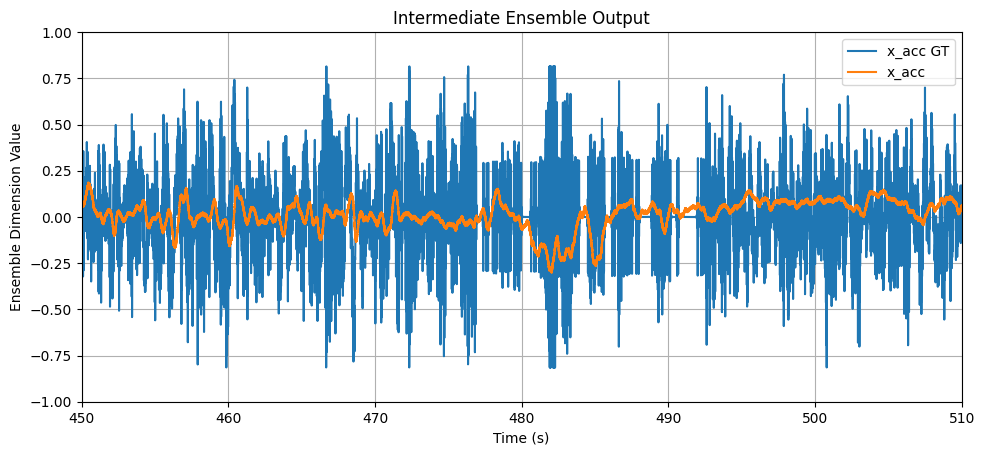

In [ ]:
dt = 0.001
runtime = 600

# Create Kinematic Approximation of Point-Mass State
class PointMass(nengo.Process):
    def __init__(self, x0, y0, vx0, vy0, **kwargs):

        self.initializers = [x0, y0, vx0, vy0]
        self.initializers = [x0, y0, vx0, vy0]
        dt_temp = kwargs.get("dt", 0.001)
        self.A = np.array([[1, 0, dt_temp, 0], [0, 1, 0, dt_temp], [0, 0, 1, 0], [0, 0, 0, 1]]) # Matrix that updates state based on previous state
        self.B = np.array([[0.5 * dt_temp * dt_temp, 0], [0, 0.5 * dt_temp * dt_temp], [dt_temp, 0], [0, dt_temp]]) # Matrix that updates state based on input

        # pass the default sizes to the Process constructor
        super().__init__(
            default_size_in=self.B.shape[1], default_size_out=self.A.shape[0], **kwargs
        )

    def make_state(self, shape_in, shape_out, dt, dtype=None):
        return {"state": np.array(self.initializers)}

    def make_step(self, shape_in, shape_out, dt, rng, state):
        assert shape_in == (self.B.shape[1],)
        assert shape_out == (self.A.shape[0],)
        A, B = self.A, self.B
        s = state["state"]

        def step(t, x):
            s[:] = A @ s + B @ x # State Update
            return s

        return step


with nengo.Network() as model:
    # Spikes
    input_node = nengo.Node(lambda t: spikes[int(t / dt) - 1, :])
    
    # Our Plant model (with initial states from the dataset)
    sim_node = nengo.Node(PointMass(px[0], py[0], vx[0], vy[0]))

    # Ensemble with signals generated by spikes
    representation_ensemble = nengo.Ensemble(n_neurons=spikes.shape[1], dimensions=4) # Assuming 4 Dimensions
    nengo.Connection(input_node, representation_ensemble.neurons, synapse=0.01)

    # Ensemble for concatenating representation and state values
    joiner_ensemble = nengo.Ensemble(n_neurons=1000, dimensions=8)
    nengo.Connection(sim_node, joiner_ensemble[:4], synapse=0.2) # State -> First 4 Dimensions
    nengo.Connection(representation_ensemble, joiner_ensemble[4:], synapse=0.2) # Signal -> Last 4 Dimensions
    nengo.Connection(joiner_ensemble, joiner_ensemble, function=lambda x: 0.9*x, synapse=0.2) # Recurrent Connection

    # Output Ensemble and Connection to-be-learned (Random initial weighting)
    output_ensemble = nengo.Ensemble(n_neurons=250, dimensions=2)
    learn_conn = nengo.Connection(joiner_ensemble, output_ensemble,  transform=np.random.normal(0, 1, (2,8)), learning_rule_type=nengo.PES(learning_rate=1e-4))

    # Connect output to error
    error_ensemble = nengo.Ensemble(n_neurons=200, dimensions=2)
    nengo.Connection(output_ensemble, error_ensemble)

    # Connect error to the learning connection
    nengo.Connection(error_ensemble, learn_conn.learning_rule)

    # Get ground truth value
    truth_node = nengo.Node(lambda t: [ax[int(t/dt) -1], ay[int(t/dt) -1]])
    #truth_node = nengo.Node(lambda t: [d2x(t)/mx, d2y(t)/mx])
    nengo.Connection(truth_node, error_ensemble, transform=-1)

    # Probe for graphing
    p_rep = nengo.Probe(representation_ensemble, synapse=0.05)
    p_state = nengo.Probe(state_ensemble)
    p_post = nengo.Probe(output_ensemble, synapse=0.05)

    # Stop learning after 80% of the running time has passed
    stop_learning = nengo.Node(output=lambda t: t >= 0.8*runtime)
    nengo.Connection(
        stop_learning, error_ensemble.neurons, transform=-20 * np.ones((error_ensemble.n_neurons, 1))
    )

with nengo.Simulator(model) as sim:
    sim.run(runtime)

fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
plt.plot(sim.trange(), ax[:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_post][:,0])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0.75 * runtime, 0.85 * runtime))
pl.set_ylim((-1, 1))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc GT", "x_acc"])
pl.grid()

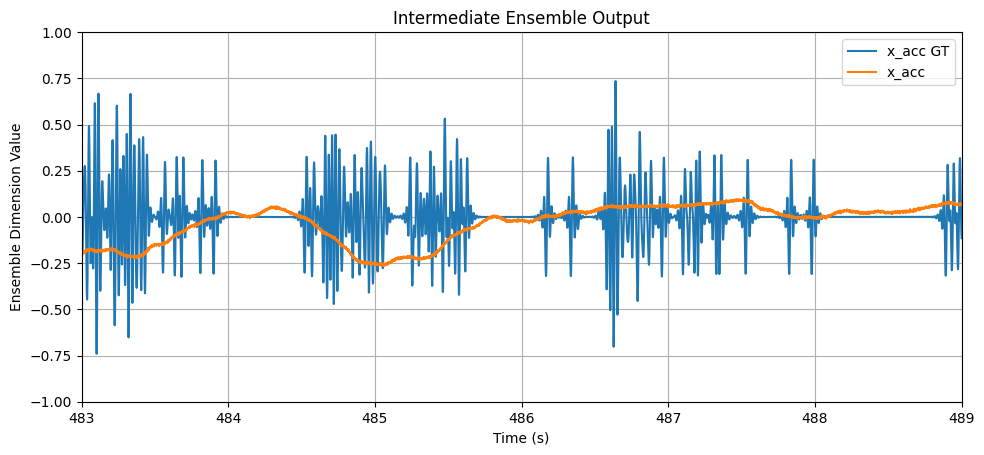

In [35]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
plt.plot(sim.trange(), ax[:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_post][:,0])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0.805 * runtime, 0.815 * runtime))
pl.set_ylim((-1, 1))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc GT", "x_acc"])
pl.grid()

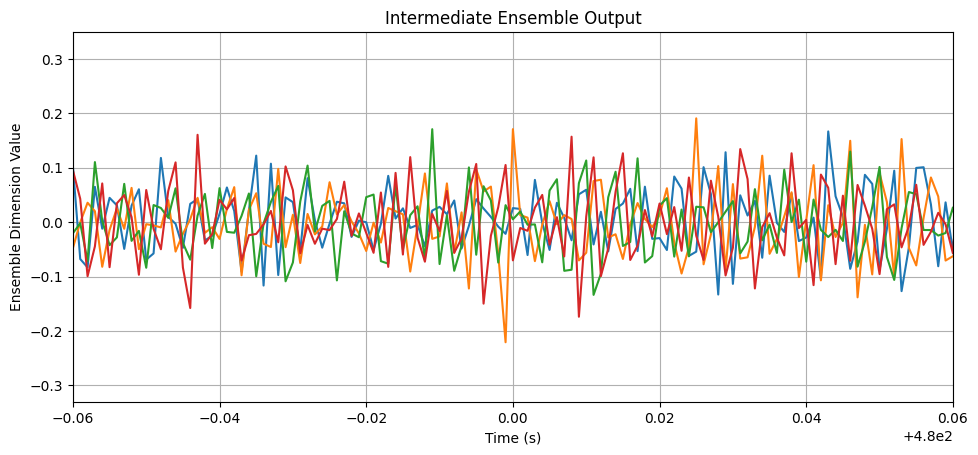

In [18]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_state])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0.7999 * runtime, 0.8001 * runtime))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.grid()